In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [2]:
USE_CUDA = True

In [13]:
## 训练数据所在位置，注意最后没有文件分隔符'/'
file_path = '/root/sharefolder/data/text_mining/sumdata/small'

## load and clean data

In [1]:
SOS_token = 0
EOS_token = 1

class Voc:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines1 = open(file_path+'/%s.txt' % lang1, encoding='utf8').read().strip().split('\n')
    lines2 = open(file_path+'/%s.txt' % lang2, encoding='utf8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(lines1[x]), normalize_string(lines2[x])] for x in range(len(lines1))]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        voc = Voc(lang1+lang2)
    else:
        voc = Voc(lang1+lang2)
        
    return voc, pairs

In [7]:
MAX_LENGTH = 50

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH 

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [14]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    voc, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        voc.index_words(pair[0])
        voc.index_words(pair[1])

    return voc, pairs

voc, pairs = prepare_data('head', 'disc', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 500 sentence pairs
Trimmed to 467 sentence pairs
Indexing words...
['it has gotten to the point where drastic action may be necessary you know those movies about ebola virus outbreaks where the guys in sterile suits come in seal off the area and completely irradiate it ?', 'livingston s revelation after rabid pursuit of clinton shows hypocrisy .']


## word embedding

In [15]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(voc, sentence):
    indexes = indexes_from_sentence(voc, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(voc, pair[0])
    target_variable = variable_from_sentence(voc, pair[1])
    return (input_variable, target_variable)

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [17]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super().__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif method == 'concat':
            self.attn = nn.Linear(hidden_size*2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)
        attn_energies = Variable(torch.zeros(seq_len)).cuda()
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            return hidden.squeeze().dot(encoder_output.squeeze())
        if self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.squeeze().dot(energy.squeeze())
            return  energy
        if self.method == 'concat':
            energy = self.attn(torch.cat(hidden, encoder_output), 1)
            energy = self.other.dot(energy.squeeze())
            return energy

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_mode, hidden_size, output_size, n_layers=1, dropout=0.1):
        super().__init__()
        # Parameters
        self.attn_mode = attn_mode
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        #Attn mode
        if attn_mode != None:
            self.attn = Attn(attn_mode, hidden_size)
            
    def forward(self, word_input, last_hidden, last_context, encoder_outputs):
        word_embeded = self.embedding(word_input).view(1, 1, -1)
        
        rnn_input = torch.cat((word_embeded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        attn_weight = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weight.bmm(encoder_outputs.transpose(0, 1))
        
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        return output, context, hidden, attn_weight

#### test model

In [20]:
encoder_test = EncoderRNN(10, 10, 2).cuda()
decoder_test = AttnDecoderRNN('general', 10, 10, 2).cuda()
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input =  Variable(torch.LongTensor([1, 2, 3])).cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size)).cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_input[i], decoder_hidden,
                                                                               decoder_context, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


## Training

In [21]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [22]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

#### parameter

In [23]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(voc.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, voc.n_words, n_layers, dropout=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [24]:
# Configuring training
n_epochs = 5000
plot_every = 20
print_every = 100

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [ ]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 32s (- 26m 44s) (100 2%) 5.0388
1m 0s (- 24m 21s) (200 4%) 4.9917
1m 32s (- 24m 9s) (300 6%) 5.3887
2m 6s (- 24m 17s) (400 8%) 5.9093
2m 40s (- 24m 6s) (500 10%) 5.9408
3m 15s (- 23m 50s) (600 12%) 5.7930
3m 49s (- 23m 29s) (700 14%) 5.4891
4m 23s (- 23m 5s) (800 16%) 5.5404
5m 0s (- 22m 47s) (900 18%) 5.5517
5m 35s (- 22m 23s) (1000 20%) 5.4236
6m 11s (- 21m 56s) (1100 22%) 5.2919
6m 46s (- 21m 27s) (1200 24%) 5.2655
7m 22s (- 20m 59s) (1300 26%) 5.2419
7m 45s (- 19m 57s) (1400 28%) 5.1373
8m 5s (- 18m 53s) (1500 30%) 4.9923
8m 34s (- 18m 13s) (1600 32%) 5.0978
9m 8s (- 17m 44s) (1700 34%) 4.9868
9m 43s (- 17m 17s) (1800 36%) 4.6921
10m 19s (- 16m 50s) (1900 38%) 4.9186
10m 56s (- 16m 24s) (2000 40%) 4.9599
11m 31s (- 15m 55s) (2100 42%) 4.5309
12m 7s (- 15m 25s) (2200 44%) 4.6612
12m 43s (- 14m 56s) (2300 46%) 4.7581
13m 20s (- 14m 27s) (2400 48%) 4.4987
13m 55s (- 13m 55s) (2500 50%) 4.3194
14m 31s (- 13m 24s) (2600 52%) 4.4014
15m 7s (- 12m 53s) (2700 54%) 4.0744
15m 44s (- 12m 

#### train loss

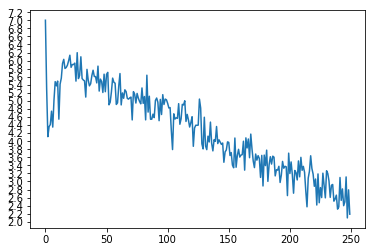

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

## Evaluating

In [27]:
def evaluate(sentence, max_length=200):
    input_variable = variable_from_sentence(voc, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(voc.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [31]:
evaluate_randomly()

> more than five years of severe food shortages and a near total breakdown in the public health system have led to devastating malnutrition in north korea and probably left an entire generation of children physically and mentally impaired a new study by international aid groups has found .
= entire generation of children in north korea impaired by malnutrition
< entire of exiles report indonesian of in north korea <EOS>



## show attention

In [32]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .
output = china s says says n . korea korean korean firing korean <EOS>


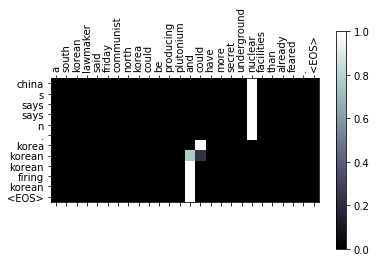

In [33]:
evaluate_and_show_attention("a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .")